# RNN for Last Name Classification

## Overview
In this deep learning project, we will train a neural network to predict the probable language of origin for a given last name or family name written in Latin alphabets. This project involves:

- Preprocessing raw text data to prepare it for input into a Recurrent Neural Network (RNN) and optionally an LSTM model.
- Using PyTorch to implement and train a recurrent neural network, leveraging modern deep learning tools.
- Evaluating the model's performance and making predictions on unseen data to assess its accuracy and generalization capabilities.

By working on this project, we aim to develop a deeper understanding of character-level NLP models, explore the intricacies of recurrent neural networks, and apply these methods to a practical problem involving multilingual last names. The ultimate goal is to accurately classify a surname into its most probable language of origin, gaining insights into how these neural architectures handle sequence data.

## Step 1: Loading Dataset

In [1]:
import os

if not os.path.exists("data"):
    !wget https://download.pytorch.org/tutorial/data.zip
    !unzip data

--2024-12-07 02:36:17--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.164.154.30, 18.164.154.17, 18.164.154.37, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.164.154.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.06s   

2024-12-07 02:36:17 (44.8 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/It

## Step 2: Library Imports

In [2]:
import os
import sys
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step 3: Implement the Neural Network

In [3]:
class RecurrentClassifier(nn.Module):
    def __init__(self, vocab_size: int, rnn_size: int, n_categories: int, num_layers: int = 1, dropout: float = 0.0, model_type: str = 'lstm'):
        super().__init__()
        self.rnn_size = rnn_size
        self.model_type = model_type

        self.embedding = nn.Embedding(vocab_size, rnn_size)

        if model_type == 'lstm':
            self.rnn = nn.LSTM(input_size=rnn_size, hidden_size=rnn_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        else:
            self.rnn = nn.RNN(input_size=rnn_size, hidden_size=rnn_size, num_layers=num_layers, nonlinearity='tanh', dropout=dropout, batch_first=True)

        self.drop = nn.Dropout(dropout)
        self.output = nn.Linear(rnn_size, n_categories)

    def forward(self, x: torch.Tensor, last_pos: torch.Tensor) -> torch.Tensor:
        embeds = self.embedding(x)
        rnn_out, _ = self.rnn(embeds)
        out = rnn_out[range(len(last_pos)), last_pos]
        out = self.drop(out)
        logits = self.output(out)
        return logits

## Step 4: Preprocess the Dataset

In [19]:
import unicodedata
import string
from io import open
import glob

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters)

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in glob.glob('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

## Step 5: Data Encoding

In [5]:
def letterToIndex(letter):
    return all_letters.index(letter)

def build_data():
    data = []
    for cat in category_lines:
        for name in category_lines[cat]:
            token = np.ones(19, dtype=np.int64) * 57  # pad index
            numerized = np.array([letterToIndex(l) for l in name])
            n = len(numerized)
            token[:n] = numerized
            data.append((token, cat_to_num[cat], n-1))
    return data

cat_to_num = dict((v,k) for k,v in enumerate(category_lines.keys()))
num_to_cat = dict(enumerate(category_lines.keys()))

In [6]:
data = build_data()
seed = 227
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
random.shuffle(data)

In [7]:
n_train = int(len(data) * 0.8)
train_data = data[:n_train]
test_data = data[n_train:]

In [8]:
len(train_data)

16059

## Step 6: Build Batch Function

In [9]:
def build_batch(dataset, indices):
    '''
    Helper function for creating a batch during training. Builds a batch
    of source and target elements from the dataset.

    Arguments:
        dataset: List[db_element] -- A list of dataset elements
        indices: List[int] -- A list of indices of the dataset to sample
    Returns:
        batch_input: List[List[int]] -- List of tensorized names
        batch_target: List[int] -- List of numerical categories
        batch_indices: List[int] -- List of starting indices of padding
    '''
    # Recover what the entries for the batch are
    batch = [dataset[i] for i in indices]
    batch_input = np.array(list(zip(*batch))[0])
    batch_target = np.array(list(zip(*batch))[1])
    batch_indices = np.array(list(zip(*batch))[2])
    return batch_input, batch_target, batch_indices

## Step 7: Train the Model

In [10]:
criterion = nn.CrossEntropyLoss()

# The build_batch function outputs numpy, but our model is built in pytorch,
# so we need to convert numpy to pytorch with the correct types.
batch_to_torch = lambda b_in,b_target,b_mask: (torch.tensor(b_in).long(),
                                               torch.tensor(b_target).long(),
                                               torch.tensor(b_mask).long())

In [11]:
# Tune these hyperparameters for a better performance
hidden_size = 128
num_layers = 2
dropout = 0.2
optimizer_class = optim.Adam
lr = 1e-3
batch_size = 128

epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("You are using", device, "for training")
list_to_device = lambda th_obj: [tensor.to(device) for tensor in th_obj]

You are using cuda for training


In [12]:
# Initialize the model
seed = 1998
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rnn_model = RecurrentClassifier(vocab_size=len(all_letters) + 1, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='rnn')
rnn_optimizer = optimizer_class(rnn_model.parameters(), lr=lr)

In [13]:
def train(model, optimizer, criterion, epochs, batch_size, seed):
    model.to(device)
    model.train()
    train_losses = []
    train_accuracies = []
    eval_accuracies = []
    for epoch in range(epochs):
        random.seed(seed + epoch)
        np.random.seed(seed + epoch)
        torch.manual_seed(seed + epoch)
        indices = np.random.permutation(range(len(train_data)))
        n_correct, n_total = 0, 0
        progress_bar = tqdm(range(0, (len(train_data) // batch_size) + 1))
        for i in progress_bar:
            batch = build_batch(train_data, indices[i*batch_size:(i+1)*batch_size])
            (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
            (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))

            logits = model(batch_input, batch_indices)
            loss = criterion(logits, batch_target)
            train_losses.append(loss.item())

            predictions = logits.argmax(dim=-1)
            n_correct += (predictions == batch_target).sum().item()
            n_total += batch_target.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10 == 0:
                progress_bar.set_description(f"Epoch: {epoch}  Iteration: {i}  Loss: {np.mean(train_losses[-10:])}")
        train_accuracies.append(n_correct / n_total * 100)
        print(f"Epoch: {epoch}  Train Accuracy: {n_correct / n_total * 100}")

        with torch.no_grad():
            indices = list(range(len(test_data)))
            n_correct, n_total = 0, 0
            for i in range(0, (len(test_data) // batch_size) + 1):
                batch = build_batch(test_data, indices[i*batch_size:(i+1)*batch_size])
                (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
                (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))

                logits = model(batch_input, batch_indices)
                predictions = logits.argmax(dim=-1)
                n_correct += (predictions == batch_target).sum().item()
                n_total += batch_target.size(0)
            eval_accuracies.append(n_correct / n_total * 100)
            print(f"Epoch: {epoch}  Eval Accuracy: {n_correct / n_total * 100}")

    to_save = {
        "history": {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "eval_accuracies": eval_accuracies,
        },
        "hparams": {
            "hidden_size": hidden_size,
            "num_layers": num_layers,
            "dropout": dropout,
            "optimizer_class": optimizer_class.__name__,
            "lr": lr,
            "batch_size": batch_size,
            "epochs": epochs,
            "seed": seed
        },
        "model": [
            (name, list(param.shape))
            for name, param in rnn_model.named_parameters()
        ]
    }
    return to_save

# Train the model
rnn_log = train(rnn_model, rnn_optimizer, criterion, epochs, batch_size, 1997)

Epoch: 0  Iteration: 119  Loss: 0.9321637749671936: 100%|██████████| 126/126 [00:02<00:00, 45.61it/s]


Epoch: 0  Train Accuracy: 61.927890902297776
Epoch: 0  Eval Accuracy: 70.43586550435865


Epoch: 1  Iteration: 119  Loss: 0.8645061910152435: 100%|██████████| 126/126 [00:00<00:00, 272.67it/s]


Epoch: 1  Train Accuracy: 73.74680864312846
Epoch: 1  Eval Accuracy: 74.79452054794521


Epoch: 2  Iteration: 119  Loss: 0.766578608751297: 100%|██████████| 126/126 [00:00<00:00, 252.15it/s]


Epoch: 2  Train Accuracy: 76.95373310915997
Epoch: 2  Eval Accuracy: 76.86176836861769


Epoch: 3  Iteration: 119  Loss: 0.6933191120624542: 100%|██████████| 126/126 [00:00<00:00, 240.61it/s]


Epoch: 3  Train Accuracy: 79.11451522510743
Epoch: 3  Eval Accuracy: 77.8082191780822


Epoch: 4  Iteration: 119  Loss: 0.6630104184150696: 100%|██████████| 126/126 [00:00<00:00, 247.02it/s]


Epoch: 4  Train Accuracy: 80.7459991282147
Epoch: 4  Eval Accuracy: 79.47696139476962


Epoch: 5  Iteration: 119  Loss: 0.6045774340629577: 100%|██████████| 126/126 [00:00<00:00, 240.30it/s]


Epoch: 5  Train Accuracy: 82.00386076343483
Epoch: 5  Eval Accuracy: 80.32378580323785


Epoch: 6  Iteration: 119  Loss: 0.5438200175762177: 100%|██████████| 126/126 [00:00<00:00, 232.24it/s]


Epoch: 6  Train Accuracy: 83.29908462544367
Epoch: 6  Eval Accuracy: 80.17434620174346


Epoch: 7  Iteration: 119  Loss: 0.4721939504146576: 100%|██████████| 126/126 [00:00<00:00, 232.53it/s]


Epoch: 7  Train Accuracy: 84.12728065259356
Epoch: 7  Eval Accuracy: 80.59775840597759


Epoch: 8  Iteration: 119  Loss: 0.5049684882164002: 100%|██████████| 126/126 [00:00<00:00, 229.46it/s]


Epoch: 8  Train Accuracy: 84.68771405442432
Epoch: 8  Eval Accuracy: 81.84308841843088


Epoch: 9  Iteration: 119  Loss: 0.4759313613176346: 100%|██████████| 126/126 [00:00<00:00, 209.90it/s]


Epoch: 9  Train Accuracy: 85.56572638395915
Epoch: 9  Eval Accuracy: 81.1706102117061


Epoch: 10  Iteration: 119  Loss: 0.4532152324914932: 100%|██████████| 126/126 [00:00<00:00, 165.90it/s]


Epoch: 10  Train Accuracy: 85.9642568030388
Epoch: 10  Eval Accuracy: 80.69738480697384


Epoch: 11  Iteration: 119  Loss: 0.4175950109958649: 100%|██████████| 126/126 [00:00<00:00, 218.98it/s]


Epoch: 11  Train Accuracy: 86.68036614982253
Epoch: 11  Eval Accuracy: 81.12079701120797


Epoch: 12  Iteration: 119  Loss: 0.45819019079208373: 100%|██████████| 126/126 [00:00<00:00, 225.80it/s]


Epoch: 12  Train Accuracy: 87.05398841770969
Epoch: 12  Eval Accuracy: 81.64383561643835


Epoch: 13  Iteration: 119  Loss: 0.3976203739643097: 100%|██████████| 126/126 [00:00<00:00, 205.95it/s]


Epoch: 13  Train Accuracy: 87.65178404632917
Epoch: 13  Eval Accuracy: 81.51930261519303


Epoch: 14  Iteration: 119  Loss: 0.39101327806711195: 100%|██████████| 126/126 [00:00<00:00, 176.99it/s]


Epoch: 14  Train Accuracy: 88.04408742761069
Epoch: 14  Eval Accuracy: 81.76836861768368


Epoch: 15  Iteration: 119  Loss: 0.41364612281322477: 100%|██████████| 126/126 [00:00<00:00, 231.90it/s]


Epoch: 15  Train Accuracy: 88.57338564045084
Epoch: 15  Eval Accuracy: 81.51930261519303


Epoch: 16  Iteration: 119  Loss: 0.32413045018911363: 100%|██████████| 126/126 [00:00<00:00, 286.07it/s]


Epoch: 16  Train Accuracy: 88.95323494613613
Epoch: 16  Eval Accuracy: 81.91780821917808


Epoch: 17  Iteration: 119  Loss: 0.3022023543715477: 100%|██████████| 126/126 [00:00<00:00, 271.49it/s]


Epoch: 17  Train Accuracy: 89.38290055420637
Epoch: 17  Eval Accuracy: 81.0211706102117


Epoch: 18  Iteration: 119  Loss: 0.32377448976039885: 100%|██████████| 126/126 [00:00<00:00, 288.03it/s]


Epoch: 18  Train Accuracy: 89.81256616227661
Epoch: 18  Eval Accuracy: 80.97135740971358


Epoch: 19  Iteration: 119  Loss: 0.31771175265312196: 100%|██████████| 126/126 [00:00<00:00, 273.18it/s]


Epoch: 19  Train Accuracy: 90.17373435456754
Epoch: 19  Eval Accuracy: 81.79327521793275


## Step 7: Evaluation

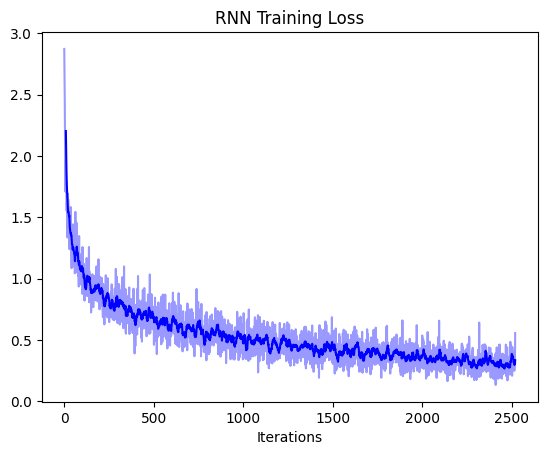

In [14]:
plt.plot(rnn_log["history"]["train_losses"], alpha=0.4, color="blue")
moving_avg = np.convolve(np.array(rnn_log["history"]["train_losses"]), np.ones(10), 'valid') / 10
plt.plot(range(9, len(rnn_log["history"]["train_losses"])), moving_avg.tolist(), color="blue")
plt.xlabel("Iterations")
plt.title("RNN Training Loss")
plt.show()

## Step 8: Test the Model with Your Own Name

In [18]:
def classify_name(name, model):
    token = np.ones(19, dtype=np.int64) * 57
    numerized = np.array([letterToIndex(l) for l in name])
    n = len(numerized)
    token[:n] = numerized
    logits = model(torch.tensor(token, dtype=torch.long)[None, :], torch.tensor([n - 1], dtype=torch.long))
    return logits.argmax(dim=-1).item()

model = rnn_model
model.eval()
model.cpu()
name = "Tanaka"
print("Predicting origin language for name: "+ name)
c = classify_name(name, model)
print(num_to_cat[c])

Predicting origin language for name: Tanaka
Japanese
